# Experiment replication

Import libraries

In [1]:
import os
import math
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import Image
from scipy.optimize import fsolve

import plotly.express as px
import plotly.graph_objects as go

Function to calculate survival probability

In [2]:
def zeta_l(lamda):
    
    func = lambda x: np.exp(lamda*(x-1)) - x
    sol = fsolve(func, 0.5)
    zeta_l = 1 - sol[0]

    return zeta_l

zeta_l(3)

0.9404797907073597

## Percolation plots

In [3]:
random_edge_selector = lambda G : list(G.edges)[random.randint(1, len(G.edges))-1]

def erdos_renyi_percolation(n, lamda):
    '''
        Returns dictionary of (edge number, C/n) pairs 
        where C is the giant cluster
    '''
    p = lamda/n
    G = nx.erdos_renyi_graph(n, p)
    m = len(G.edges)
    edge_to_frac = dict()
    edge_to_cluster_sizes = dict()
    deleted_edges = []

    for edge_num in range(1, m+1):
        # Remove edge
        deleted_edge = random_edge_selector(G)
        deleted_edges.append(deleted_edge)
        G.remove_edges_from([deleted_edge])
    
        # Find max cluster size
        clusters = dict(enumerate(nx.connected_components(G), start=1))
        cluster_sizes = {i : len(clusters[i]) for i in clusters}
        max_cluster_size = max(list(cluster_sizes.values()))
        frac = max_cluster_size / n
    
        # Create dictionaries
        edge_to_frac[m - edge_num] = frac
        edge_to_cluster_sizes[m - edge_num] = max_cluster_size

    return [G, deleted_edges, edge_to_frac, edge_to_cluster_sizes]

In [4]:
def er_percolation_plot(n, lamda):
    '''
        Generates percolation evolution graph for ER graph
    '''
    [_, _, edge_to_frac, _] = erdos_renyi_percolation(n, lamda)
    
    r = np.array(list(edge_to_frac.keys())) / n
    frac_array = np.array(list(edge_to_frac.values()))
    
    # Percolation graph
    fig1 = px.line(x=r, y=frac_array, 
                    title="$n = {0} \quad \lambda = {1}$".format(n, lamda), 
                    range_x=[0, 1.525], range_y=[0, 1.025])
    
    # Survival probability graph
    z = zeta_l(lamda)
    fig2 = px.line(x=r, y=len(r)*[z], range_x=[0, 1.525], range_y=[0, 1.025])
    fig2.update_traces(line=dict(color='red', width=1, dash='dash'))

    fig = go.Figure(data=fig1.data + fig2.data)
    fig.update_layout(title="$n = {0} \quad \lambda = {1}$".format(n, lamda), xaxis_title="r", yaxis_title="C/n")
    
    print("\n-------------------")
    print("Percolation ER plot")
    print("-------------------\n")
    print("Survival probability ζ = %f" %z)
    
    fig.show()

In [5]:
er_percolation_plot(1_000 , 3)


-------------------
Percolation ER plot
-------------------

Survival probability ζ = 0.940480


In [6]:
def multi_percolation_plot(n, lamda_list):
    '''
        Generates multiple percolation graphs for different values of lamda.
    '''
    edge_to_frac_list = [erdos_renyi_percolation(n, lamda)[2] for lamda in lamda_list]
    r_list = [np.array(list(edge_to_frac.keys())) / n for edge_to_frac in edge_to_frac_list]
    frac_array_list = [np.array(list(edge_to_frac.values())) for edge_to_frac in edge_to_frac_list]
    fig = go.Figure()

    for i in range(len(edge_to_frac_list)):
        fig.add_trace(go.Scatter(x=r_list[i], 
                                 y=frac_array_list[i],
                                 mode='lines',
                                 name="λ = {0}".format(lamda_list[i])))

        fig.update_layout(title="n = {0}".format(n), xaxis_title="r", yaxis_title="C/n")

    fig.show()

In [7]:
lamda_list = [2, 3, 4, 5]

In [8]:
multi_percolation_plot(500, lamda_list)

In [9]:
multi_percolation_plot(1000, lamda_list)

In [10]:
multi_percolation_plot(2000, lamda_list)

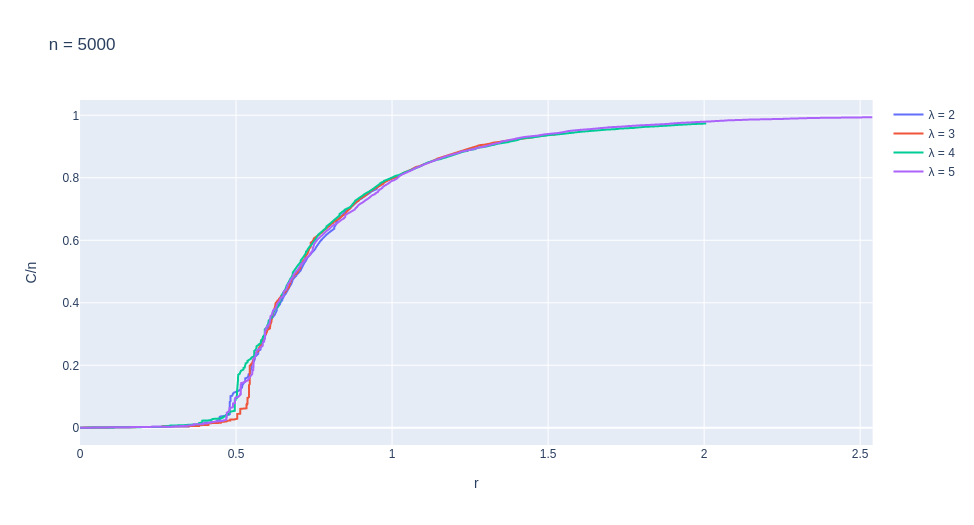

In [11]:
Image(filename='figures/5_000.png')

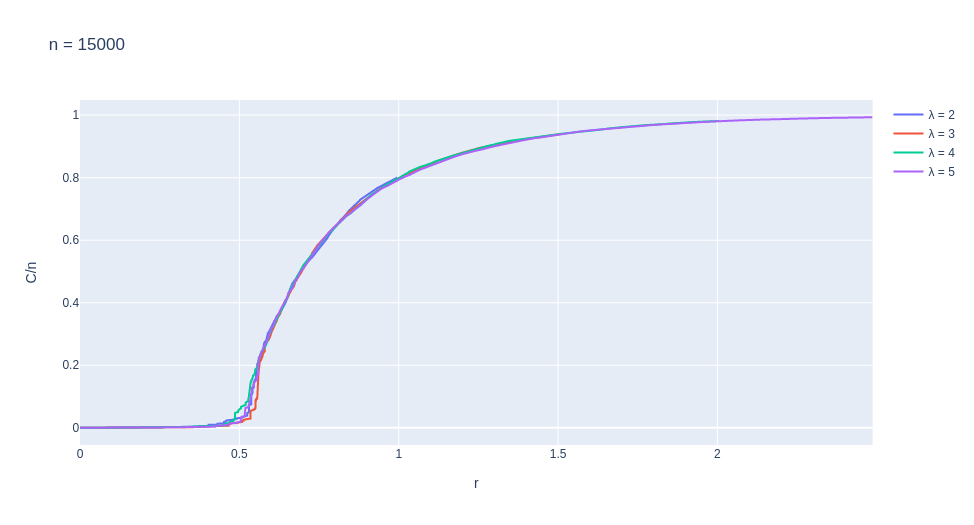

In [12]:
Image(filename='figures/15_000.png')

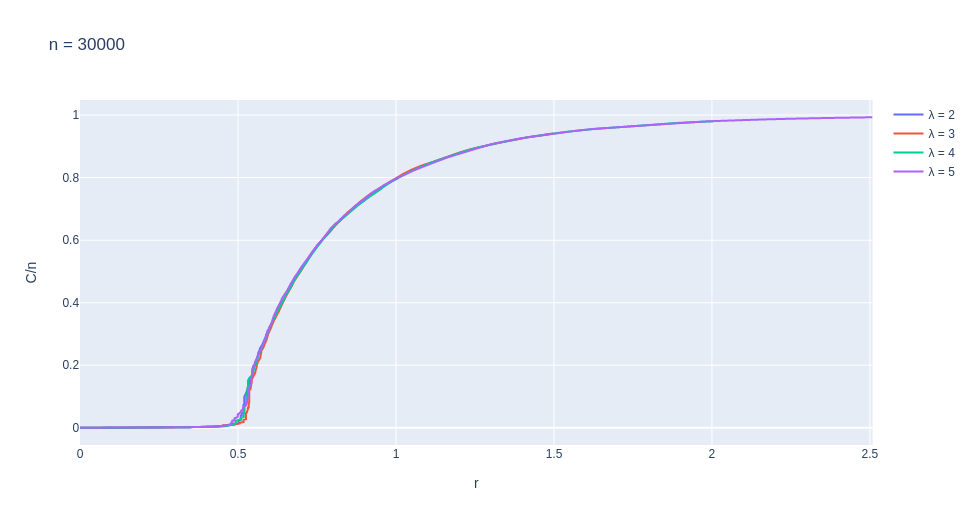

In [13]:
Image(filename='figures/30_000.png')

<Figure size 640x480 with 0 Axes>

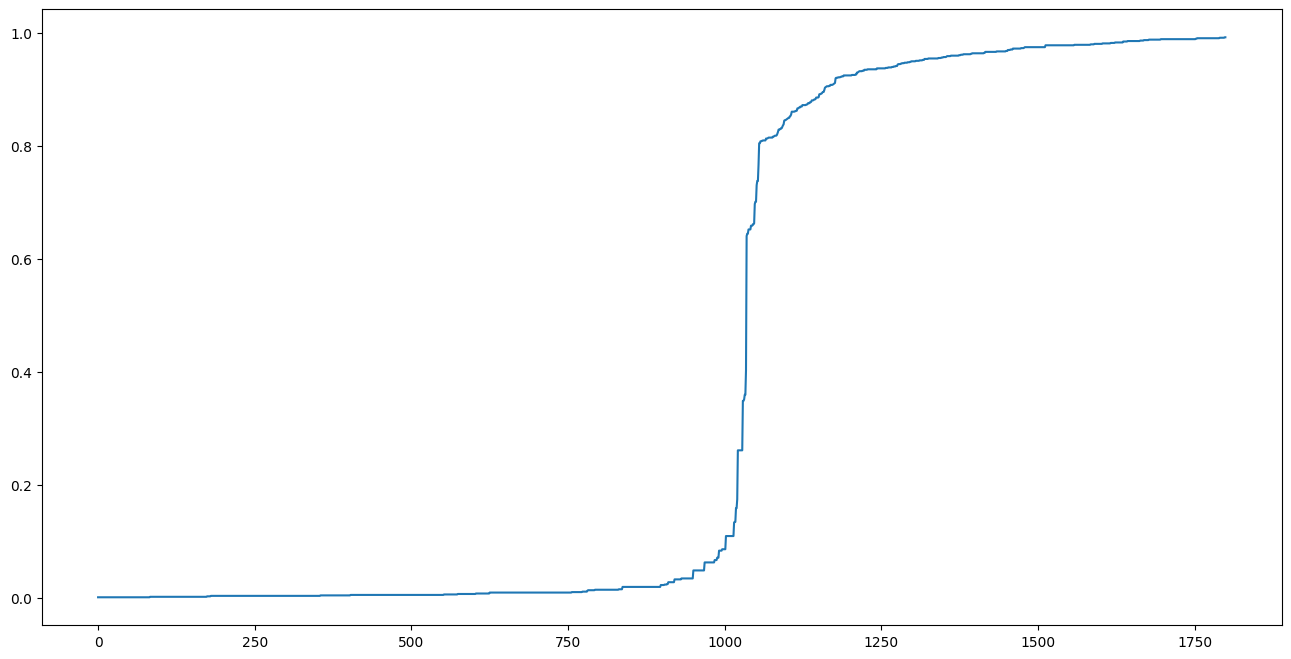

In [14]:
def pr_graph(N):
    # Create an empty graph object
    g = nx.Graph()
    nb = int(1.5*N)  
        
    # Adding nodes
    g.add_nodes_from(range(1, N + 1))
    frac = np.zeros(nb)
    for i in range(nb):
        nonedges = list(nx.non_edges(g))
        e1 = random.choice(nonedges)
        e2 = random.choice(nonedges)
        p1 = len(nx.shortest_path(g,e1[0]).keys())*len(nx.shortest_path(g,e1[1]).keys())
        p2 = len(nx.shortest_path(g,e2[0]).keys())*len(nx.shortest_path(g,e2[1]).keys())
        if p1<=p2:
            g.add_edge(e1[0], e1[1])
        else:
            g.add_edge(e2[0], e2[1])
        frac[i] = len(sorted(nx.connected_components(g), key=len, reverse=True)[0])/N
        
    return frac


frac = pr_graph(1200)

# for i in range(5):
#      frac += pr_graph(1200)
# frac /= 6

fig = plt.figure()
fig, ax = plt.subplots(figsize=(16, 8))
plt.plot(frac)
plt.show()

In [15]:
def combined_percolation_plot(n):
    '''
        Generates combined percolation evolution graph
    '''
    lamda = float(input("Input λ for ER graph = "))
    [_, _, edge_to_frac, _] = erdos_renyi_percolation(n, lamda)
    
    # Erdos-Renyi
    frac_array = np.array(list(edge_to_frac.values()))
    # PR graph
#     frac = pr_graph(n)

    r_er = np.array(list(edge_to_frac.keys())) / n
    r_pr = np.array(range(len(frac)))/n
  
    fig1 = px.line(x=r_er, y=frac_array, range_x=[0, 1.525], range_y=[0, 1.025], labels={"x" : "r", "y" : "C/n"})
    
    fig2 = px.line(x=r_pr, y=frac, range_x=[0, r_pr[:-1]], range_y=[0, 1.025], labels={"x" : "r", "y" : "C/n"})
    fig2.update_traces(line_color='red')

    fig = go.Figure(data=fig1.data + fig2.data)
    fig.update_layout(title="Combined percolation plot", xaxis_title="r", yaxis_title="C/n")
    
    fig.show()

In [16]:
combined_percolation_plot(1200)

Input λ for ER graph = 3


## Percolation animation

In [17]:
def edge_gc_plot(n, lamda):
    '''
        Generates edge to giant cluster size graph
    '''
    G, deleted_edges, _, edge_to_cluster_sizes = erdos_renyi_percolation(n, lamda)
    
    edges = list(edge_to_cluster_sizes.keys())
    sizes = list(edge_to_cluster_sizes.values())
    
    fig = px.line(x=edges, y=sizes, 
                  title= "$n = {0} \quad \lambda = {1}$".format(n, lamda), 
                  labels={"x" : "Edges", "y" : "Giant cluster size"})
    
    print("\n--------------------------------")
    print("Edge to giant cluster size graph")
    print("--------------------------------")
    
    fig.show()
    
    return [G, deleted_edges]

In [21]:
def preparation():
    '''
        Initial inputs
    '''
    n = int(input("Input number of vertices = "))
    lamda = int(input("Input λ = "))
    
    G, deleted_edges = edge_gc_plot(n, lamda)
    edge_range = map(int, input("Input range of edge numbers from plot = ").split(','))
    before_index, after_index = edge_range
    
    return n, lamda, G, deleted_edges, before_index, after_index

Input number of vertices = 300
Input λ = 20

--------------------------------
Edge to giant cluster size graph
--------------------------------


Input range of edge numbers from plot = 80, 550


<Figure size 640x480 with 0 Axes>

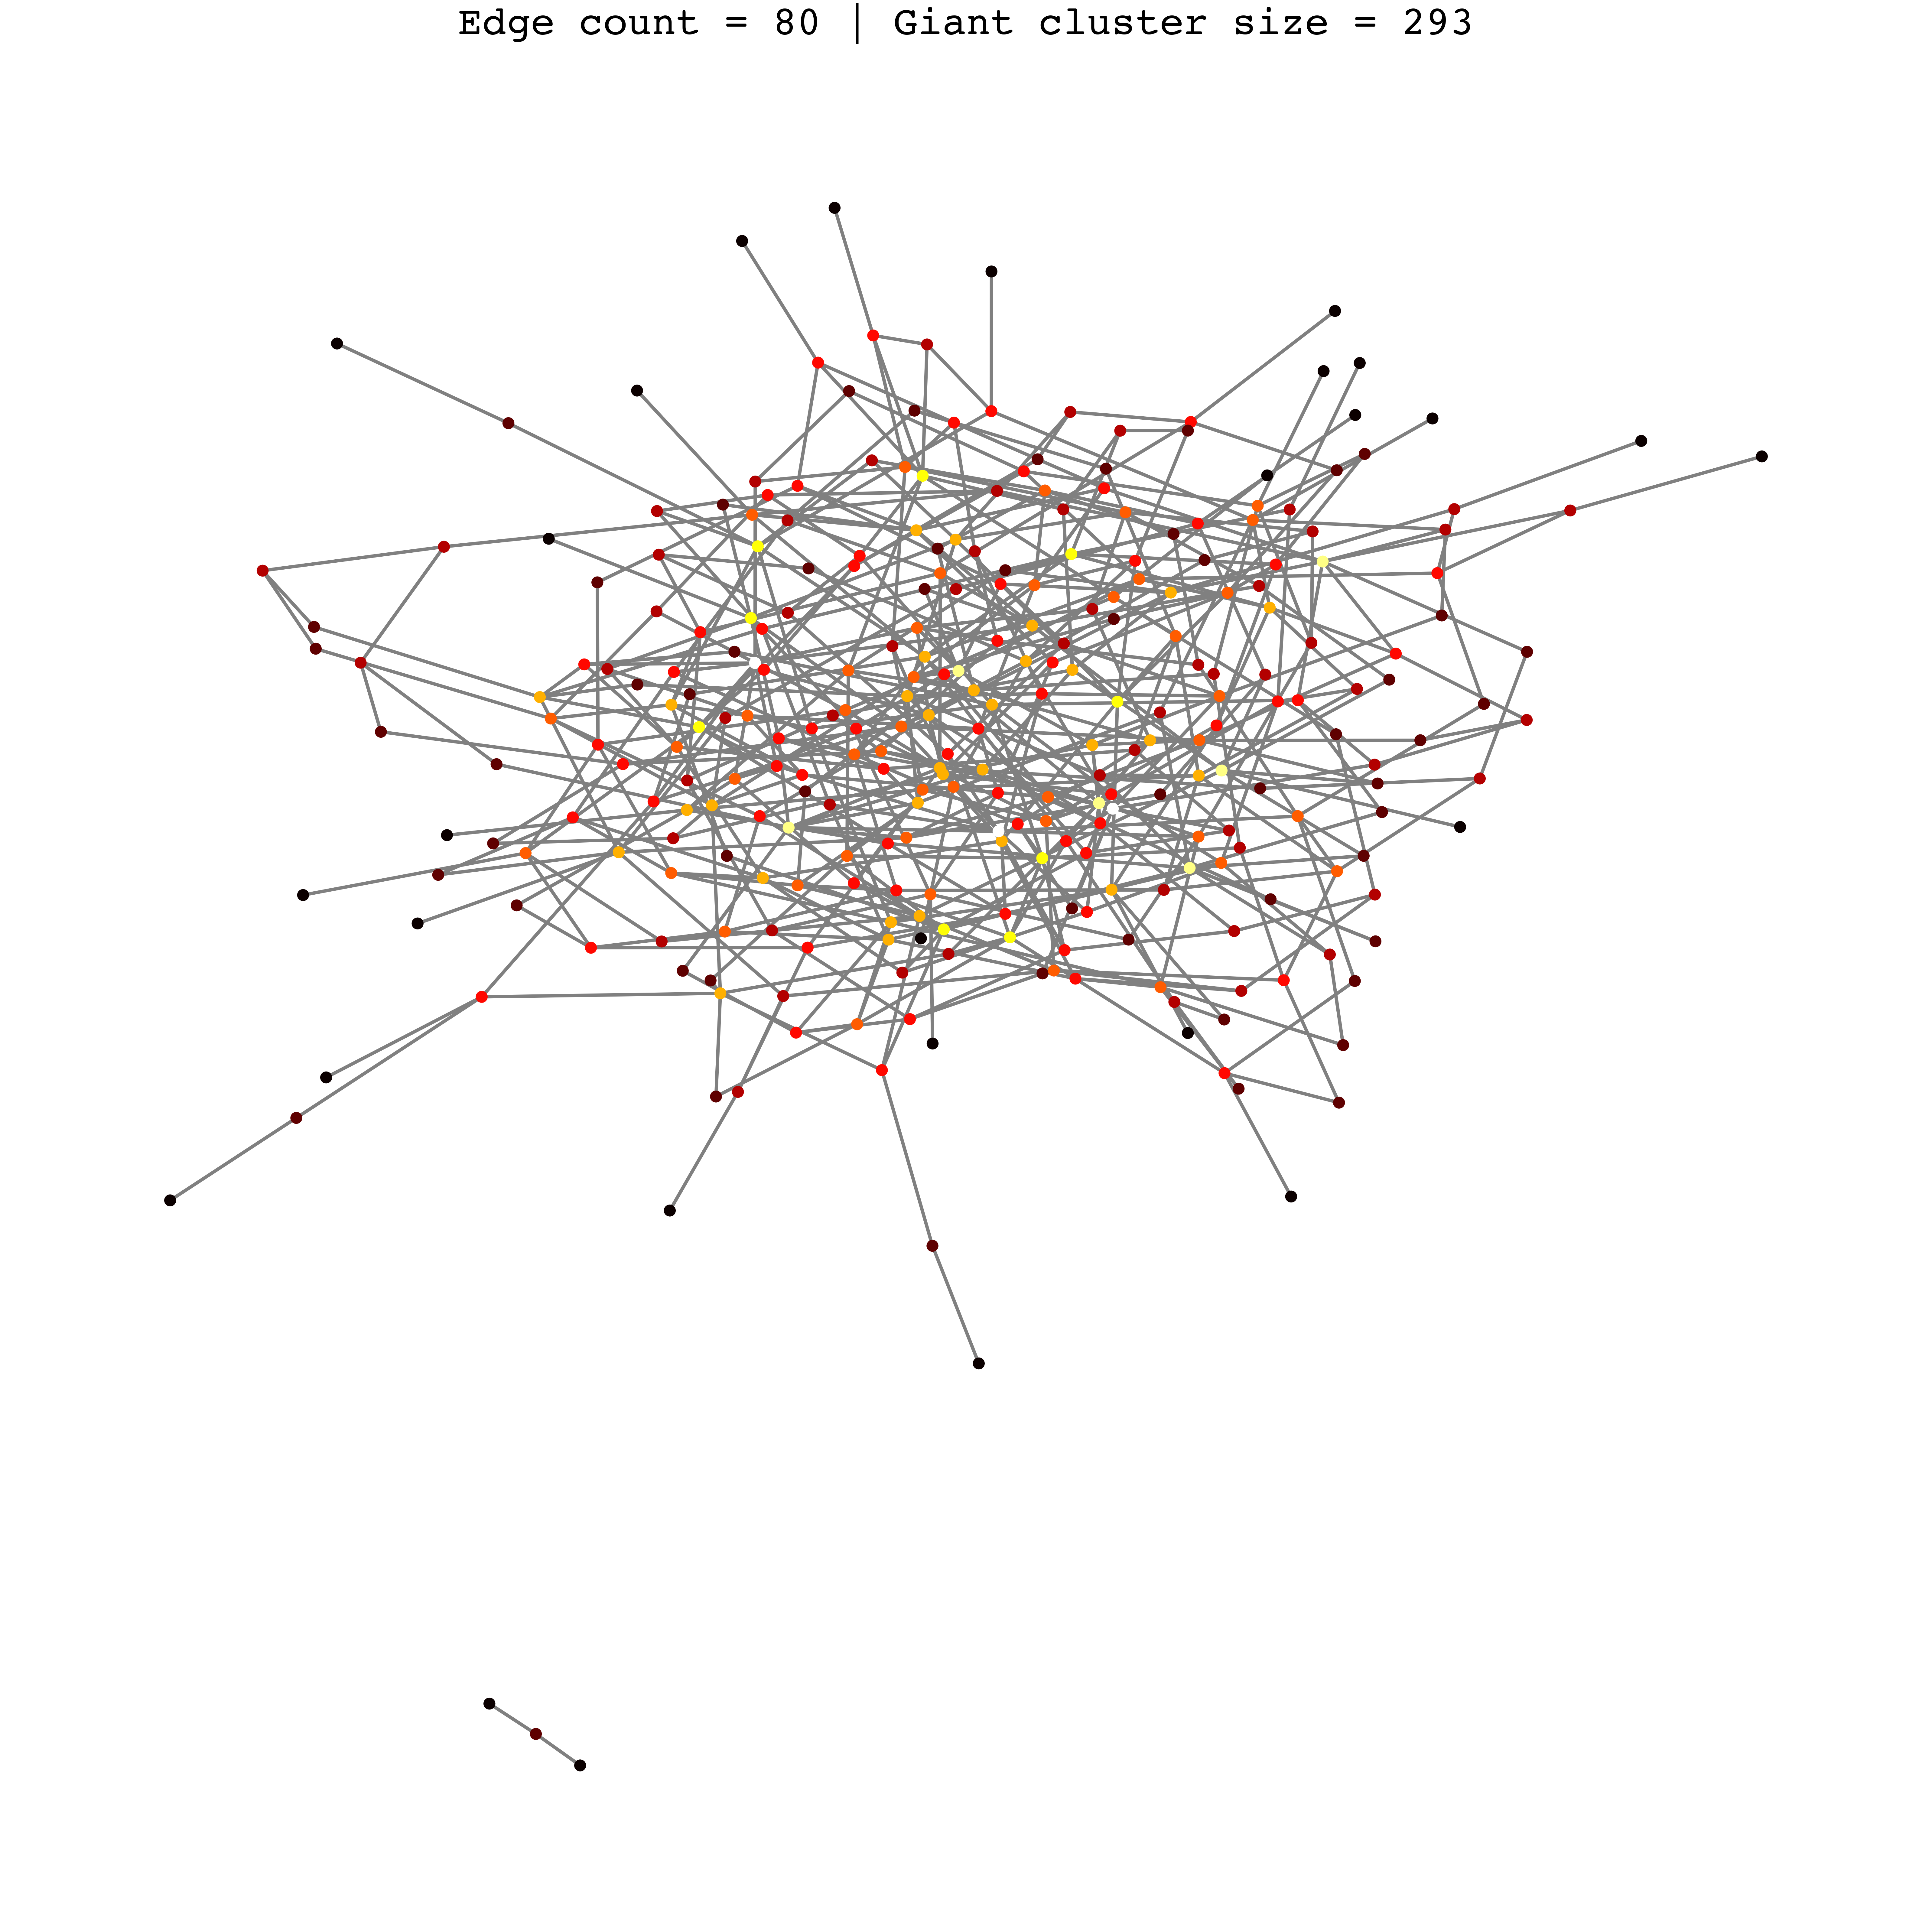

In [35]:
font = {"fontname": "Courier", "color": "k", "fontsize": 96}

fig = plt.figure()
fig, ax = plt.subplots(figsize=(64, 64))

n, lamda, G, deleted_edges, before_index, after_index = preparation()
total_edges = after_index - before_index + 1

G_new = nx.Graph()
G_new.add_nodes_from(G.nodes())
nx.draw_networkx(G_new, with_labels=False)
G_new.add_edges_from(deleted_edges[:before_index])

def animate(frame):
    
    ax.clear() 
    current_index = before_index + frame
    a, b = deleted_edges[current_index]
    G_new.add_edge(a, b)
    
    clusters = dict(enumerate(nx.connected_components(G_new), start=1))
    cluster_sizes = {i : len(clusters[i]) for i in clusters}
    max_cluster_size = max(list(cluster_sizes.values()))
    clusters_nodes = clusters.values()
    
    threshold = 2
    shown_nodes = [node for node_set in clusters_nodes for node in node_set if len(node_set) >= threshold]
    shown_edges = [edge for edge in G_new.edges() if edge[0] in shown_nodes and edge[1] in shown_nodes]
    node_degrees = np.array([G_new.degree[node] for node in shown_nodes])
    
    options = {"node_size": 750, "node_color": node_degrees, "nodelist": shown_nodes,
               "edge_color": "grey", "edgelist": shown_edges, "linewidths": 1,
               "width": 8, "cmap": "hot"}
    
    ax.set_title("Edge count = " + str(current_index) + " | Giant cluster size = " + str(max_cluster_size), font)
    
    fig.tight_layout()
    ax.set_axis_off()
    nx.draw_networkx(G_new, with_labels=False, **options)
    
anim = animation.FuncAnimation(fig, animate, frames=total_edges, interval=1, repeat=True)
anim.save('perc_new.mp4', writer = 'ffmpeg', fps=5)